In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import uniform, randint
from tensorflow.keras import layers, models
from hyperopt import fmin, tpe, hp, Trials
from sklearn.metrics import recall_score
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

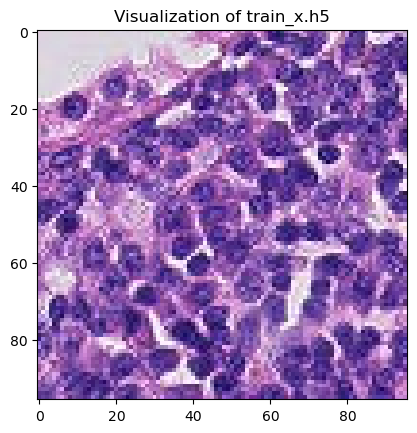

In [2]:
import os
import h5py
import matplotlib.pyplot as plt

folder_path = '/Users/ramsesnestor/Desktop/data'

file_to_dataset = {
    'train_x.h5': 'x',
    'train_y.h5': 'y',
    'valid_x.h5': 'x',
    'valid_y.h5': 'y',
    'test_x.h5': 'x',
    'test_y.h5': 'y'
}

for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
       
        dataset = file[dataset_name]
        
        
        data = dataset[:]
        
 
        if 'train_x.h5' in filename:
            plt.imshow(data[0], cmap='gray')  
            plt.title(f'Visualization of {filename}')
            plt.show()


In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = None, None, None, None, None, None


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
        
        dataset = file[dataset_name]
        
        
        if 'train_x.h5' in filename:
            x_train = dataset[:]
        elif 'train_y.h5' in filename:
            y_train = dataset[:]
        elif 'valid_x.h5' in filename:
            x_valid = dataset[:]
        elif 'valid_y.h5' in filename:
            y_valid = dataset[:]
        elif 'test_x.h5' in filename:
            x_test = dataset[:]
        elif 'test_y.h5' in filename:
            y_test = dataset[:]

In [4]:
len(x_train), len(y_train), len(x_valid), len(y_valid), len(x_test), len(y_test)

(262144, 262144, 32768, 32768, 32768, 32768)

In [5]:
#checking for class imbalance

unique_classes, class_counts = np.unique(y_train, return_counts=True)

for i, class_count in enumerate(class_counts):
    class_name = unique_classes[i]
    print(f"Class {class_name}: {class_count} samples")


Class 0: 131072 samples
Class 1: 131072 samples


In [6]:
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
def generate_roi(patch):
    start = (patch.shape[0] - 32) // 2
    end = start + 32
    return patch[start:end, start:end]

train_X_roi = np.array([generate_roi(patch) for patch in x_train])
valid_X_roi = np.array([generate_roi(patch) for patch in x_valid])
test_X_roi = np.array([generate_roi(patch) for patch in x_test])


In [8]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [16]:


x_train_subset, x_valid_subset, y_train_subset, y_valid_subset = train_test_split(
    train_X_roi, y_train, train_size=.8, random_state=42
)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(x_train_subset)

In [11]:
x_valid_subset, _, y_valid_subset, _ = train_test_split(
    x_valid, y_valid, train_size=1200, random_state=42
)


In [64]:
x_test_subset, _, y_test_subset, _ = train_test_split(
    train_X_roi, y_train, train_size=52000, random_state=42
)


In [9]:
from sklearn.model_selection import train_test_split


X_train, x_temp, y_train_s, y_temp = train_test_split(train_X_roi, y_train, test_size=0.2, random_state=42)


X_valid, X_test, y_valid_s, y_test_s = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


# Simple

In [17]:

model_1 = Sequential([
    Flatten(input_shape=(32, 32, 3)),  
    Dense(16, activation='relu'), 
    BatchNormalization(),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_1.compile(
    optimizer=Adagrad(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall']
)

# Summarize the model architecture
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 16)                49168     
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49,249
Trainable params: 49,217
Non-trainable params: 32
_________________________________________________________________


In [19]:
history_1 = model_1.fit(x_train_subset, y_train_subset,
                        validation_data=(x_valid_subset, y_valid_subset),
                         epochs=10, batch_size=16, shuffle=True)

Epoch 1/10


2023-09-29 14:31:07.061132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.6823 - recall: 0.6702

2023-09-29 14:32:41.541581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - 108s 8ms/step - loss: 0.6078 - accuracy: 0.6823 - recall: 0.6702 - val_loss: 0.6014 - val_accuracy: 0.6844 - val_recall: 0.5669
Epoch 2/10
13108/13108 [==============================] - 108s 8ms/step - loss: 0.5954 - accuracy: 0.6958 - recall: 0.6829 - val_loss: 0.5853 - val_accuracy: 0.7055 - val_recall: 0.7189
Epoch 3/10
13108/13108 [==============================] - 107s 8ms/step - loss: 0.5917 - accuracy: 0.6991 - recall: 0.6947 - val_loss: 0.5812 - val_accuracy: 0.7071 - val_recall: 0.6953
Epoch 4/10
13108/13108 [==============================] - 107s 8ms/step - loss: 0.5888 - accuracy: 0.7017 - recall: 0.7024 - val_loss: 0.5840 - val_accuracy: 0.7122 - val_recall: 0.7701
Epoch 5/10
13108/13108 [==============================] - 107s 8ms/step - loss: 0.5876 - accuracy: 0.7025 - recall: 0.7072 - val_loss: 0.5798 - val_accuracy: 0.7086 - val_recall: 0.6912
Epoch 6/10
13108/13108 [==============================] - 107s 8ms/step - loss: 0

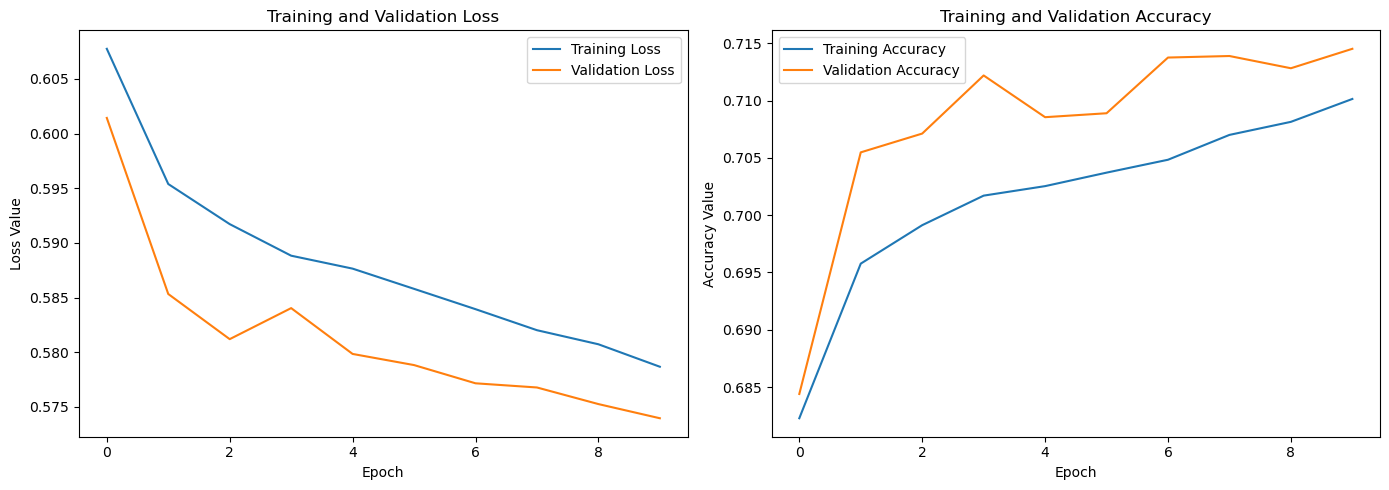

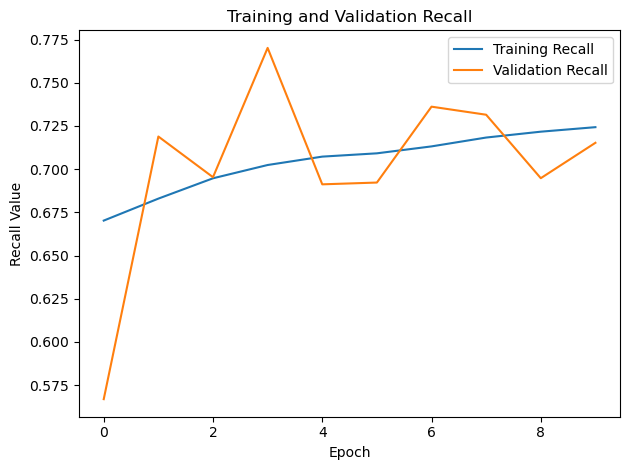

In [20]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_1.history['recall'], label='Training Recall')
plt.plot(history_1.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# Dense

In [71]:

model_2 = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(2, activation='relu'),
    #Dropout(0.5),
    Dense(2, activation='relu'),
    #Dropout(0.5),
    Dense(2, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer=Adagrad(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

model_2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 3072)              0         
                                                                 
 dense_64 (Dense)            (None, 2)                 6146      
                                                                 
 dense_65 (Dense)            (None, 2)                 6         
                                                                 
 dense_66 (Dense)            (None, 2)                 6         
                                                                 
 dense_67 (Dense)            (None, 1)                 3         
                                                                 
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_2 = model_2.fit(x_train_subset, y_train_subset,
                        validation_data=(x_valid_subset, y_valid_subset),
                         epochs=20, batch_size=16, shuffle=True)

Epoch 1/20


2023-09-29 20:02:19.676568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.6037 - recall: 0.6986

2023-09-29 20:03:48.037156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - 102s 8ms/step - loss: 0.6504 - accuracy: 0.6037 - recall: 0.6986 - val_loss: 0.6382 - val_accuracy: 0.6120 - val_recall: 0.7452
Epoch 2/20
13108/13108 [==============================] - 98s 7ms/step - loss: 0.6355 - accuracy: 0.6138 - recall: 0.7386 - val_loss: 0.6321 - val_accuracy: 0.6158 - val_recall: 0.7663
Epoch 3/20
13108/13108 [==============================] - 98s 8ms/step - loss: 0.6313 - accuracy: 0.6177 - recall: 0.7587 - val_loss: 0.6288 - val_accuracy: 0.6189 - val_recall: 0.7568
Epoch 4/20
13108/13108 [==============================] - 99s 8ms/step - loss: 0.6288 - accuracy: 0.6209 - recall: 0.7726 - val_loss: 0.6268 - val_accuracy: 0.6223 - val_recall: 0.7701
Epoch 5/20
13108/13108 [==============================] - 98s 7ms/step - loss: 0.6271 - accuracy: 0.6230 - recall: 0.7795 - val_loss: 0.6253 - val_accuracy: 0.6244 - val_recall: 0.7851
Epoch 6/20
13108/13108 [==============================] - 98s 7ms/step - loss: 0.6259

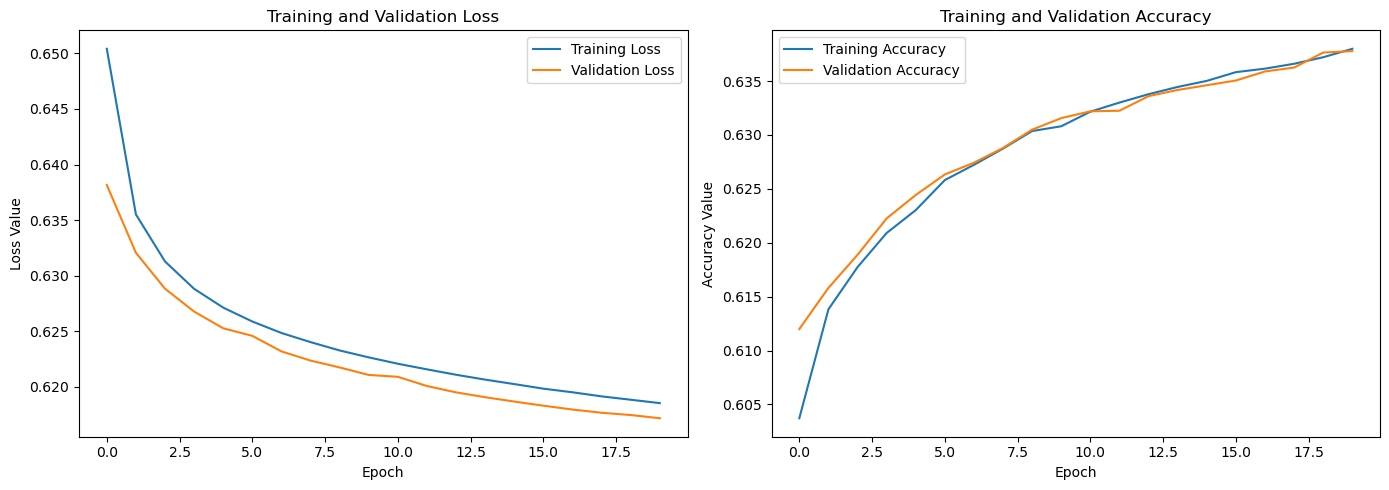

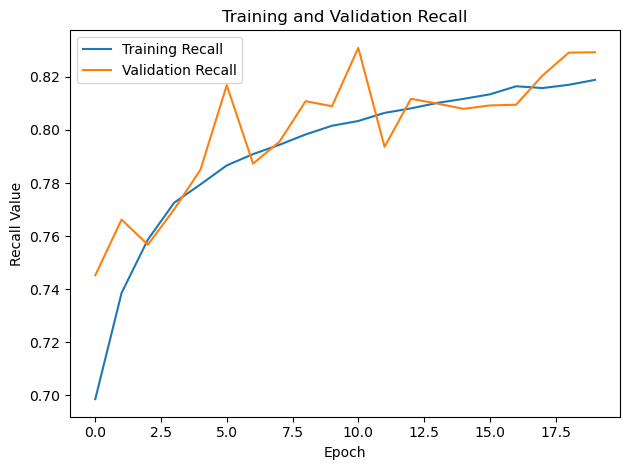

In [73]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_2.history['recall'], label='Training Recall')
plt.plot(history_2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()




In [77]:
model3 = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(2, activation='relu'),
    #Dropout(0.5),
    Dense(2, activation='relu'),
    #Dropout(0.5),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=Adagrad(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

model3.summary()

history3 = model3.fit(x_train_subset, y_train_subset,
                        validation_data=(x_valid_subset, y_valid_subset),
                         epochs=20, batch_size=16, shuffle=True)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 3072)              0         
                                                                 
 dense_76 (Dense)            (None, 2)                 6146      
                                                                 
 dense_77 (Dense)            (None, 2)                 6         
                                                                 
 dense_78 (Dense)            (None, 2)                 6         
                                                                 
 dense_79 (Dense)            (None, 2)                 6         
                                                                 
 dense_80 (Dense)            (None, 1)                 3         
                                                                 
Total params: 6,167
Trainable params: 6,167
Non-train

2023-09-29 21:28:20.742437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.6018 - recall: 0.7159

2023-09-29 21:30:01.226968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - 115s 9ms/step - loss: 0.6633 - accuracy: 0.6018 - recall: 0.7159 - val_loss: 0.6485 - val_accuracy: 0.6116 - val_recall: 0.7279
Epoch 2/20
13108/13108 [==============================] - 113s 9ms/step - loss: 0.6443 - accuracy: 0.6123 - recall: 0.7386 - val_loss: 0.6386 - val_accuracy: 0.6148 - val_recall: 0.7282
Epoch 3/20
13108/13108 [==============================] - 113s 9ms/step - loss: 0.6373 - accuracy: 0.6163 - recall: 0.7710 - val_loss: 0.6336 - val_accuracy: 0.6179 - val_recall: 0.7612
Epoch 4/20
13108/13108 [==============================] - 113s 9ms/step - loss: 0.6333 - accuracy: 0.6180 - recall: 0.7873 - val_loss: 0.6303 - val_accuracy: 0.6191 - val_recall: 0.8036
Epoch 5/20
13108/13108 [==============================] - 113s 9ms/step - loss: 0.6307 - accuracy: 0.6197 - recall: 0.7997 - val_loss: 0.6281 - val_accuracy: 0.6213 - val_recall: 0.8170
Epoch 6/20
13108/13108 [==============================] - 113s 9ms/step - loss: 0

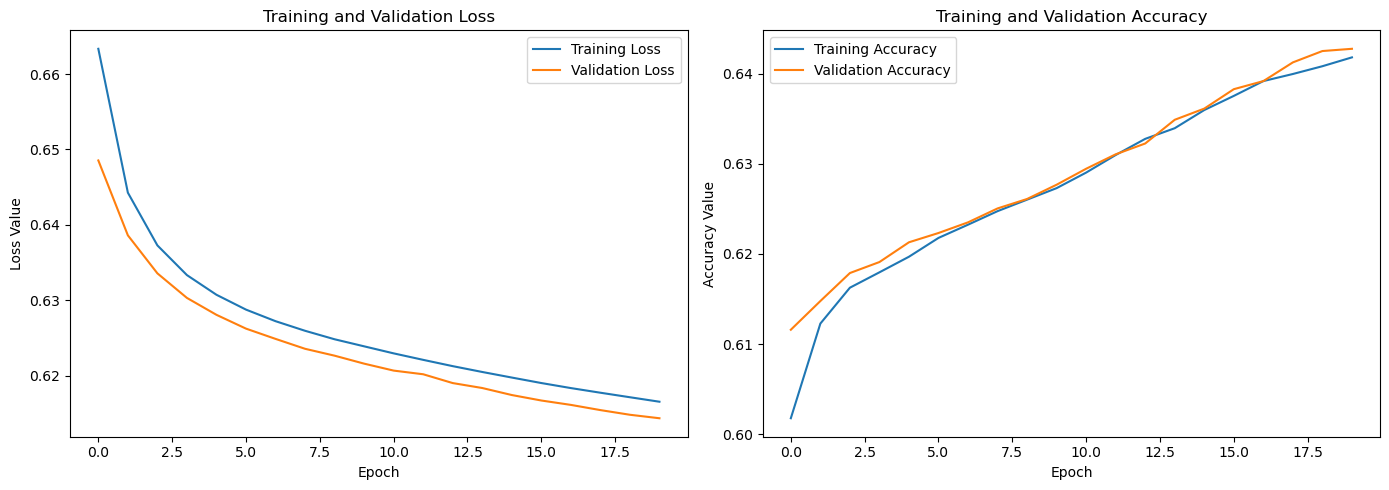

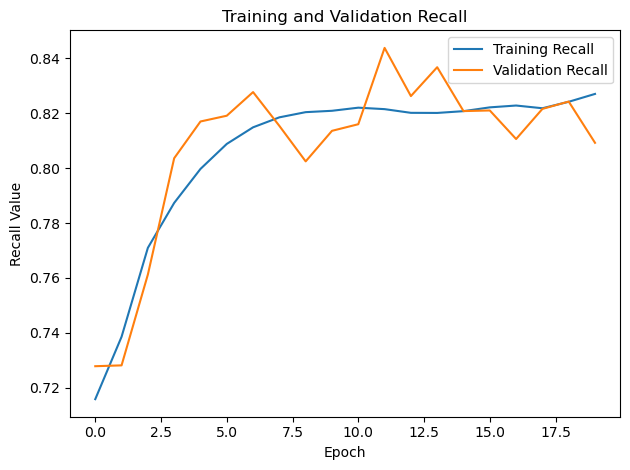

: 

In [79]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history3.history['recall'], label='Training Recall')
plt.plot(history3.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()


In [78]:
y_pred = model3.predict(x_test_subset)
y_pred = (y_pred > 0.5).astype(int)

recall = recall_score(y_test_subset, y_pred)
print('Recall: %.3f' % recall)

   1/1625 [..............................] - ETA: 8:31

2023-09-29 22:06:27.919859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1625/1625 [==============================] - 3s 2ms/step
Recall: 0.807


# CNN 1

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)




model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=x_train.shape[1:]),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn.summary()

Physical devices cannot be modified after being initialized
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                            

/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
#class_weights = {0: 1, 1: 2}

history_cnn = model_cnn.fit(x_train, y_train,
                        validation_data=(x_valid, y_valid), epochs=10)
                         #steps_per_epoch=len(x_train_subset)/16, epochs=10) #class_weight=class_weights)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

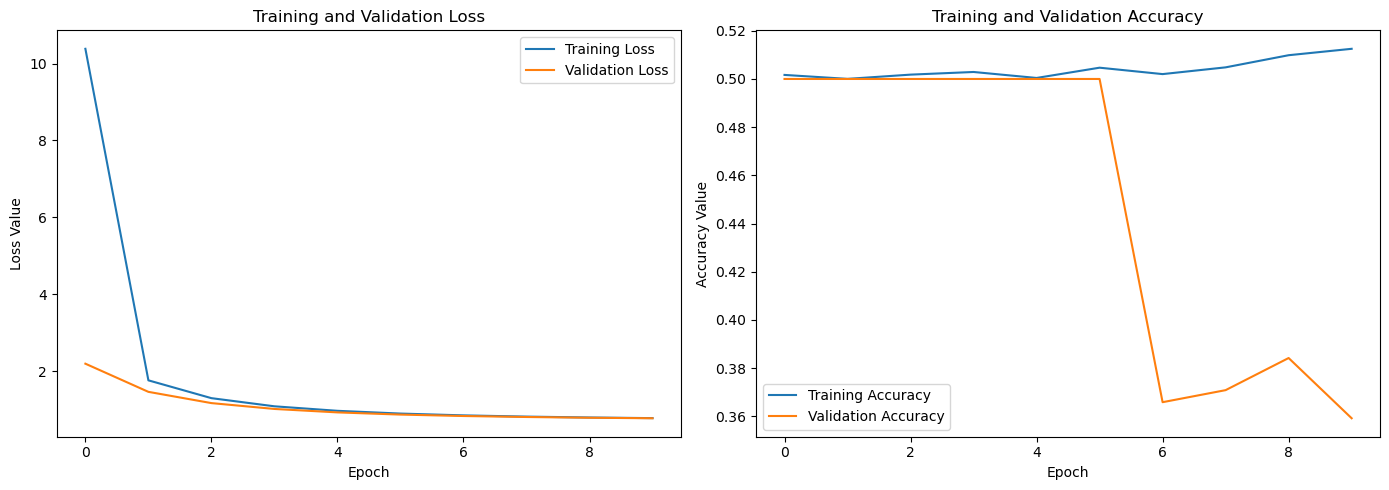

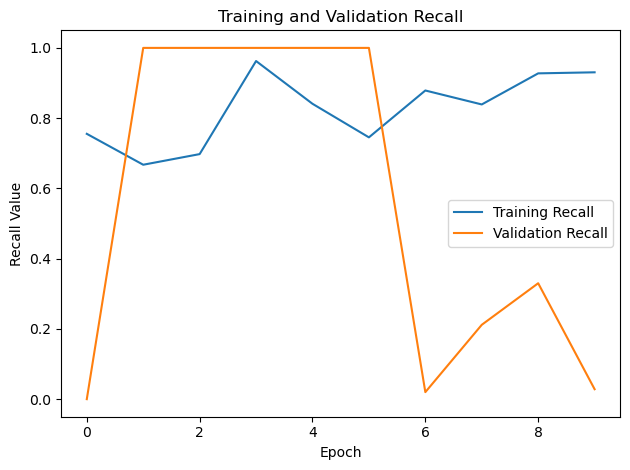

In [ ]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn.history['recall'], label='Training Recall')
plt.plot(history_cnn.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# CNN2 SGD optimizer

In [ ]:
model_cnn2 = Sequential() #sgd optimizer

# Convolutional layers
model_cnn2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(512, activation='relu'))
model_cnn2.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
model_cnn2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn2.summary()

In [ ]:
history_cnn2 = model_cnn2.fit(datagen.flow(x_train_final, y_train_final, batch_size=16), 
                                    validation_data=(x_val_final, y_val_final),
                                    steps_per_epoch=len(x_train_final)/16, epochs=10)

In [ ]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['loss'], label='Training Loss')
plt.plot(history_cnn2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn2.history['recall'], label='Training Recall')
plt.plot(history_cnn2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# CNN with hyperparams from random search :(

In [14]:

model_cnn3 = Sequential()

# Convolutional layers
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.5))

model_cnn3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.5))

model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.5))

    # Flatten layer to convert the 2D feature maps to 1D feature vectors
model_cnn3.add(Flatten())

    # Fully connected layers
model_cnn3.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.5))

    # Output layer
model_cnn3.add(Dense(1, activation='sigmoid'))

# Compile the CNN model
optimizer = Adagrad(learning_rate=0.06516691237683736)
model_cnn3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn3.summary()

2023-09-22 20:05:30.351672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-22 20:05:30.352377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                        

In [15]:
history_cnn3 = model_cnn3.fit(datagen.flow(x_train_subset, y_train_subset, batch_size=16),
                        validation_data=(x_valid_subset, y_valid_subset),
                         steps_per_epoch=len(x_train_subset)/16, epochs=10)

Epoch 1/10


2023-09-22 20:05:30.747401: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-22 20:05:31.139515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - ETA: 0s - loss: 1.2742 - accuracy: 0.7146 - recall: 0.7342

2023-09-22 20:06:25.590991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 56s 17ms/step - loss: 1.2742 - accuracy: 0.7146 - recall: 0.7342 - val_loss: 76.0617 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 2/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.6266 - accuracy: 0.7449 - recall: 0.7560 - val_loss: 293.9859 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.6077 - accuracy: 0.7528 - recall: 0.7461 - val_loss: 495.1024 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 4/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.5958 - accuracy: 0.7601 - recall: 0.7504 - val_loss: 660.4536 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/10
3125/3125 [==============================] - 54s 17ms/step - loss: 0.5876 - accuracy: 0.7637 - recall: 0.7493 - val_loss: 512.0167 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 6/10
3125/3125 [==============================] - 55s 17

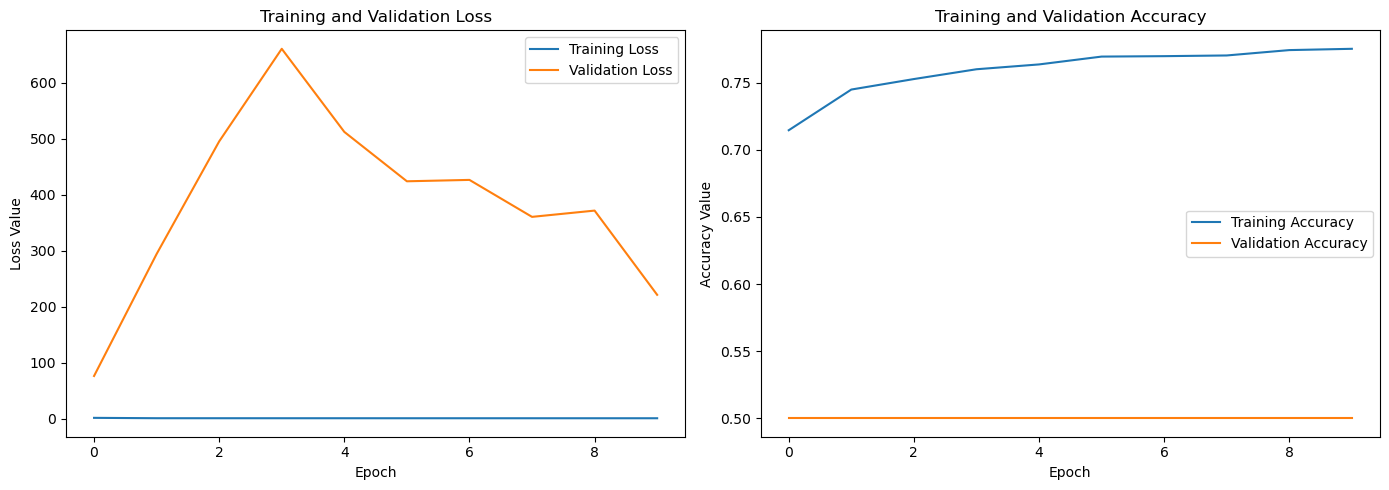

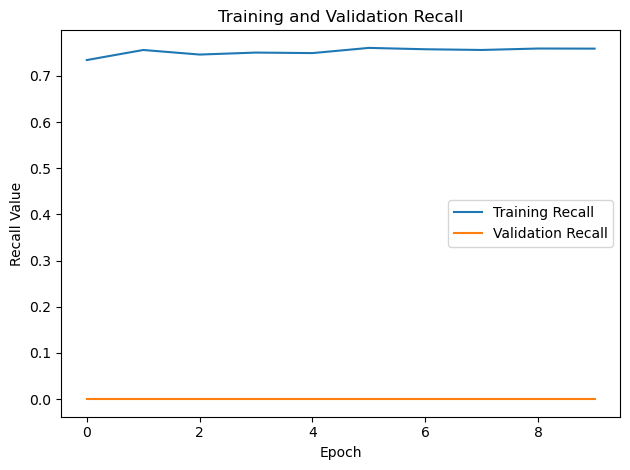

In [16]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn3.history['loss'], label='Training Loss')
plt.plot(history_cnn3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn3.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn3.history['recall'], label='Training Recall')
plt.plot(history_cnn3.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

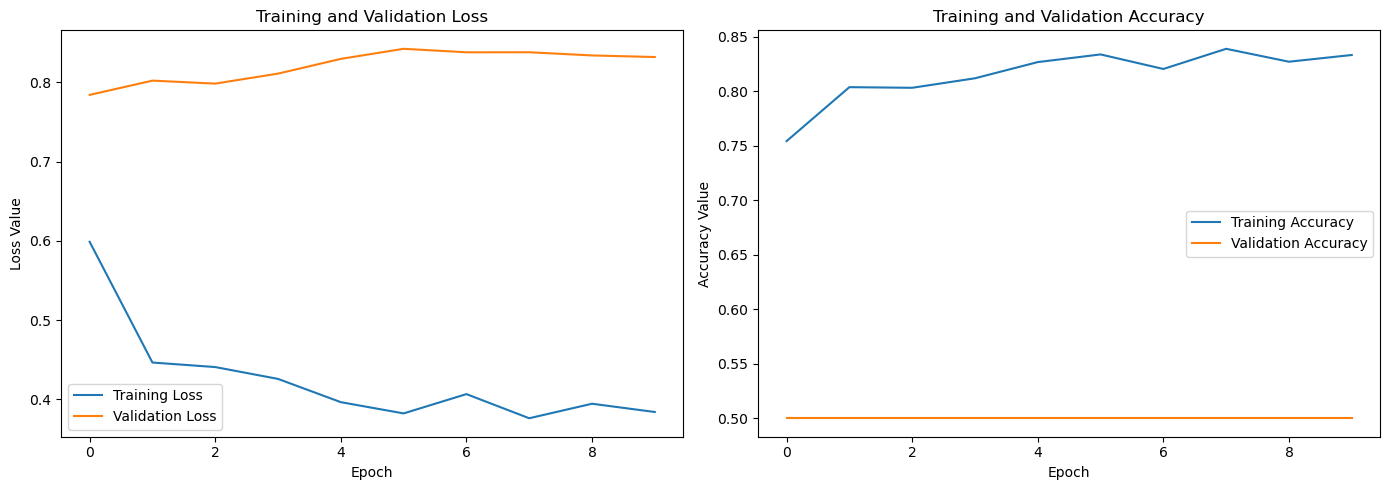

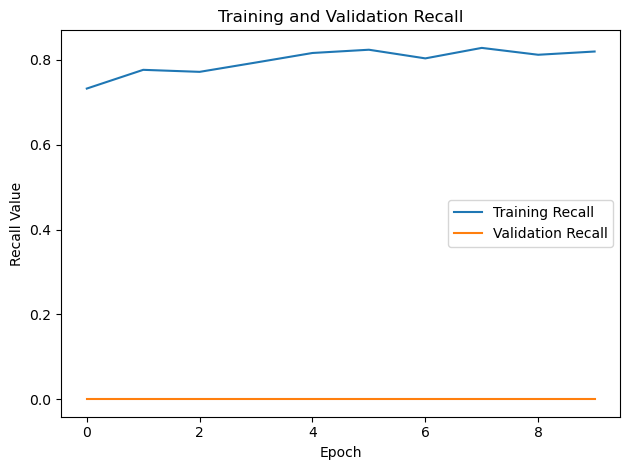

In [21]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define a function to create your model
def create_model(optimizer='adam'):
    model = Sequential([
        Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(4, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        Dropout(0.2),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])
    return model

# Create the KerasClassifier wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=16)

# Define the parameter grid for the grid search
param_grid = {
    'optimizer': [Adagrad(lr=0.001), Adam(lr=0.001), RMSprop(lr=0.001)]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the grid search to the training data
grid_search_result = grid_search.fit(x_train_subset, y_train_subset)

# Print the best parameters and score
print("Best parameters: ", grid_search_result.best_params_)
print("Best score: ", grid_search_result.best_score_)

In [10]:
model11 = Sequential([
    Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    #Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model11.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history11 = model11.fit(X_train, y_train_s, epochs=15, validation_data=(X_valid, y_valid_s), batch_size=16)

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-10-02 14:04:17.197534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-02 14:04:17.199285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/15


2023-10-02 14:04:19.768825: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-02 14:04:20.247325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.7808 - recall: 0.7745

2023-10-02 14:06:50.515528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13108/13108 [==============================] - 158s 12ms/step - loss: 0.4723 - accuracy: 0.7808 - recall: 0.7745 - val_loss: 0.4253 - val_accuracy: 0.8099 - val_recall: 0.8061
Epoch 2/15
13108/13108 [==============================] - 156s 12ms/step - loss: 0.4330 - accuracy: 0.8032 - recall: 0.7920 - val_loss: 0.4323 - val_accuracy: 0.8030 - val_recall: 0.8635
Epoch 3/15
13108/13108 [==============================] - 160s 12ms/step - loss: 0.4161 - accuracy: 0.8135 - recall: 0.8023 - val_loss: 0.3975 - val_accuracy: 0.8247 - val_recall: 0.8143
Epoch 4/15
 2333/13108 [====>.........................] - ETA: 2:05 - loss: 0.4060 - accuracy: 0.8199 - recall: 0.8032

KeyboardInterrupt: 

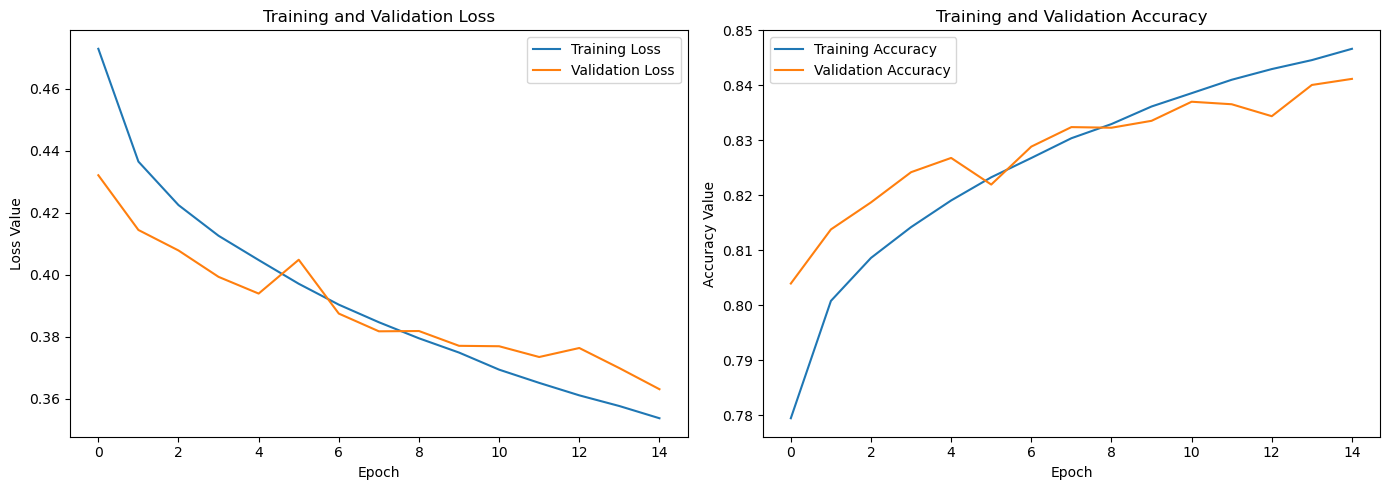

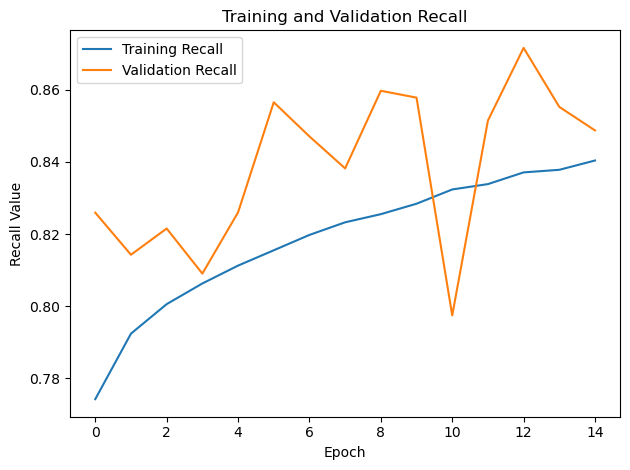

In [11]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history11.history['loss'], label='Training Loss')
plt.plot(history11.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history11.history['accuracy'], label='Training Accuracy')
plt.plot(history11.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history11.history['recall'], label='Training Recall')
plt.plot(history11.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
y_pred = model11.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

recall = recall_score(y_test_s, y_pred)
print('Recall: %.3f' % recall)

  1/820 [..............................] - ETA: 2:29

2023-10-02 13:45:22.766361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


820/820 [==============================] - 3s 3ms/step
Recall: 0.845


In [ ]:
odel_dummy = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dummy.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history_dummy = model_dummy.fit(X_train, y_train_s, epochs=5, validation_data=(X_valid, y_valid_s), batch_size=16)
